This notebook lets you generate the elastic response for a unit disk load for terrestrial hydrology and ice sheet applications. Depending on your area of study, the Greens functions generated here are likely inaccurate (especially if your grid cells contain both ocean/lakes and land): use SPOTL/LOADDEF for better results.

Susheel Adusumilli, Scripps Institution of Oceanography

Last edit: May 10, 2020

In [1]:
import os
import numpy as np
import scipy.io as sio
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Define the domain of interest:

In [2]:
grid_cell = 0.25 #0.25 degree resolution grid
earth_radius = 6371.

dx = 0.1
r = grid_cell*earth_radius*np.pi/360
print('The radius of the disk is: ' + str(r) + ' km')
print('The disk is approximated using grid cells of size: ' + str(dx) + ' km')
rho_w = 1000

The radius of the disk is: 13.899365830569842 km
The disk is approximated using grid cells of size: 0.1 km


We first need the Green's function for a point load. For this, I used LoadDef:
https://github.com/hrmartens/LoadDef

I ran the code in doc/quick_start.txt but first changed the disk_size value in compute_greens_functions.py to 0.25deg to match the size of the disc load considered here. I also edited the code so that it computed the value of the Green's function at 0.00001deg angular distance in addition to the default Farrell spacing (you can change this in compute_greens_functions.py). We want the output for the CM reference frame.

I included this output in the data/ folder in the repo.

We shall now generate the displacement response for a 1m water load over a disk with the above radius 'r'.

In [3]:
cm_PREM_ldef = np.loadtxt('data/cm_PREM.txt',skiprows=5) #Load Green's functions
km_ld = cm_PREM_ldef[:,0]*earth_radius*np.pi/180;
u_m_kg = cm_PREM_ldef[:,1]

x_ = np.arange(-r,r,dx)
y_ = np.arange(-r,r,dx)

x,y = np.meshgrid(x_,y_)
mask = np.sqrt(x**2 + y**2) <= r #Approximation of a disk

dg_cm = np.arange(0,5001,1) #Go up to 5000 km away from source
ug_cm = np.zeros_like(dg_cm)

for i in np.arange(0,len(x)):
    for j in np.arange(0,len(y)):
        if mask[i,j]:
            d_=np.sqrt((x[i,j] - dg_cm)**2 + y[i,j]**2)
            fi = interp1d(km_ld, u_m_kg, kind ='slinear', fill_value="extrapolate")
            ug_cm = ug_cm + rho_w*fi(d_)*(dx*1000)**2

approx_factor = (np.pi*r**2)/(np.sum(mask[:])*dx**2)
area_disk = (np.sum(mask[:])*dx**2)
print('We are able to approximate the disk with: ' + str(100/approx_factor) + '% accuracy')

We are able to approximate the disk with: 99.95358096265012% accuracy


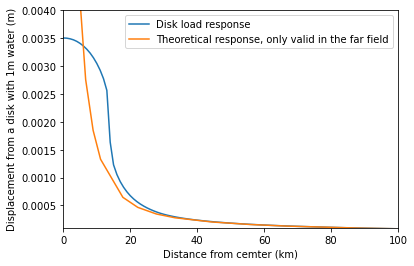

In [4]:
plt.plot(dg_cm,np.abs(ug_cm),label='Disk load response')
plt.plot(km_ld, np.abs(u_m_kg*(area_disk*1e6)*rho_w),label='Theoretical response, only valid in the far field')
plt.xlim([0,100])
plt.ylim([1e-4,0.004])
plt.legend()
plt.ylabel('Displacement from a disk with 1m water (m)');
plt.xlabel('Distance from cemter (km)');

In [6]:
#If you only want the unit load Greens's functions (e.g., for ice sheet applications), stop here and save the data using 
#sio.savemat('greens_functions_025_deg.mat',{'dg_cm':dg_cm, 'ug_cm':ug_cm})

#Otherwise the next step is to set up a Greens function matrix (G) so that G.m = d,
#where m is the load and d is the displacement. For terrestrial hydrology applications, 
#I need a good land/ocean mask – I use GMT here

In [6]:
#First, define the domain of interest
min_lat = 52
max_lat = 72
min_lon = -175
max_lon = -132

gmt_R = '-R' + str(min_lon) + '/' + str(max_lon) + '/' + str(min_lat) + '/' + str(max_lat)
os.system('gmt grdlandmask -I' + str(grid_cell) + ' -r '+ gmt_R + ' -N0/1/1/1/1 -Gdomain_mask.nc');
os.system('gmt grdmath ' + gmt_R + ' AREA domain_mask.nc MUL = domain_mask_area.nc');

In [7]:
from netCDF4 import Dataset, num2date
domain_mask_area = Dataset('domain_mask_area.nc')

lat_grid = domain_mask_area.variables['lat'][:]
lon_grid = domain_mask_area.variables['lon'][:]
area_grid = domain_mask_area.variables['z'][:]
lon_grid,lat_grid = np.meshgrid(lon_grid,lat_grid);

glon = lon_grid[area_grid!=0]; glat = lat_grid[area_grid!=0];
area = area_grid[area_grid!=0];

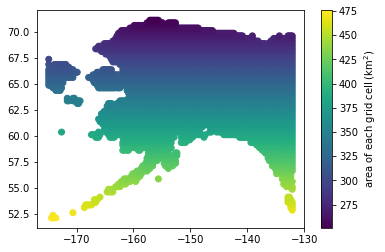

In [8]:
plt.scatter(glon,glat,c=area)
cbar = plt.colorbar();
cbar.set_label("area of each grid cell (km$^2$)")

Clearly, using a disk load with the same area isn't great if we are working with a lat/lon grid in high latitude regions because there are large variations in grid cell area accross the domain. Use a polar stereo grid for better results! Let's stick with this for now, though, and generate the 'G' matrix in our G.m=d formulation

In [9]:
#Get locations of GPS stations 
gps_station_locations = sio.loadmat('data/gps_station_locations.mat')
slon = gps_station_locations['slon']
slat = gps_station_locations['slat']
G = np.zeros((np.size(slat),np.size(glat)))

In [10]:
from geopy.distance import geodesic #Or use your favourite way to get distances between two lat/lons!
fi = interp1d(dg_cm,ug_cm,kind ='slinear',fill_value="extrapolate")
for i in np.arange(0,len(slat)):
    for j in np.arange(0,len(glon)):
        dist = geodesic((slat[i],slon[i]),(glat[i],glon[i])).km
        G[i,j] = (area[j]/area_disk)*fi(dist)
sio.savemat('data/greens_matrix_025_deg_ALASKA.mat',{'slat':slat, 'slon':slon, 'glat':glat, 'glon':glon, 'G':G})

This 'G' matrix now can be used to estimate displacements due to a load (simply multiply G.m) or it can be used for inversions of loads using observed displacements (solve the matrix equation G.m = d).